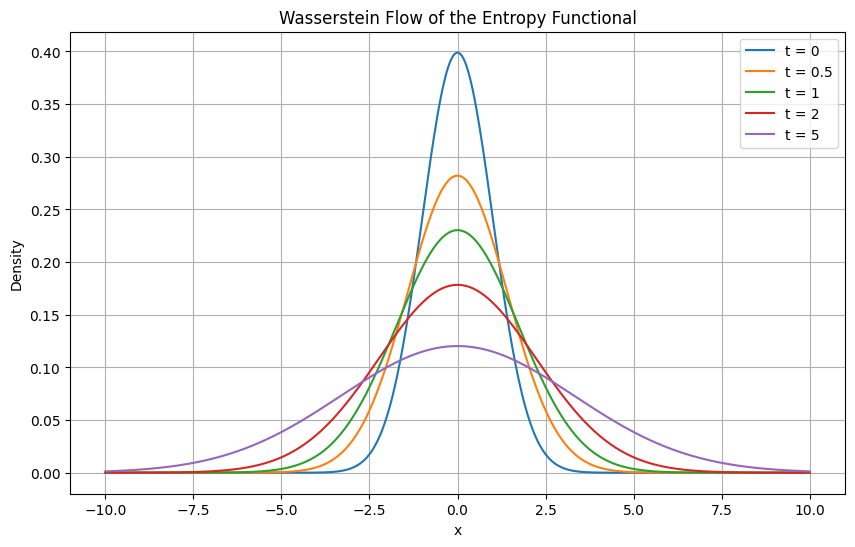

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 1.0
t_values = [0, 0.5, 1, 2, 5]
x = np.linspace(-10, 10, 400)

# Function to compute the density at time t
def gaussian_density(x, sigma, t):
    sigma_t = np.sqrt(sigma**2 + 2 * t)
    return 1 / np.sqrt(2 * np.pi * sigma_t**2) * np.exp(-x**2 / (2 * sigma_t**2))

# Plot
plt.figure(figsize=(10, 6))
for t in t_values:
    rho_t = gaussian_density(x, sigma, t)
    plt.plot(x, rho_t, label=f't = {t}')

plt.title('Wasserstein Flow of the Entropy Functional')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig('gradient_flow.png')
plt.show()

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

MMD result of X and Y is 0.2361689805984497


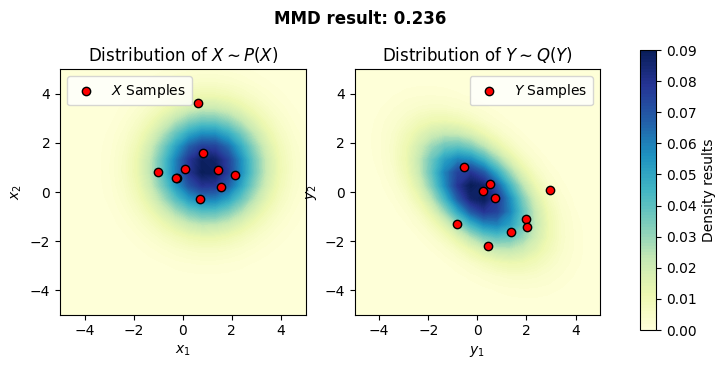

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="rbf")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout()
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title("Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title("Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import sqrtm

# Function to compute MMD between two sets of samples using RBF kernel
def compute_mmd(X, Y, gamma=0.5):
    K_XX = rbf_kernel(X, X, gamma=gamma)
    K_YY = rbf_kernel(Y, Y, gamma=gamma)
    K_XY = rbf_kernel(X, Y, gamma=gamma)
    return np.mean(K_XX) + np.mean(K_YY) - 2 * np.mean(K_XY)

# Function to compute Wasserstein distance between two Gaussians analytically
def wasserstein_distance(cov1, cov2):
    sqrt_cov1 = sqrtm(cov1)
    term = sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1)
    return np.trace(cov1 + cov2 - 2 * term)

# Parameters
num_samples = 1000
mu1 = np.array([0, 0])
mu2 = np.array([0, 0])
cov1 = np.array([[1, 0], [0, 1]])

# Generate samples for Gaussian A
A_samples = np.random.multivariate_normal(mu1, cov1, num_samples)

# Range of correlation coefficients
correlations = np.linspace(-1, 1, 100)
mmd_values = []
wasserstein_values = []

# Gamma values for sensitivity analysis
gamma_values = [0.01,0.1, 0.5, 1.0, 5.0, 10.0]

# Dictionary to store MMD values for different gammas
mmd_values_dict = {gamma: [] for gamma in gamma_values}

# Compute MMD and Wasserstein distance for each correlation and each gamma
for rho in correlations:
    cov2 = np.array([[1, rho], [rho, 1]])
    B_samples = np.random.multivariate_normal(mu2, cov2, num_samples)
    wd = wasserstein_distance(cov1, cov2)
    wasserstein_values.append(wd)

    for gamma in gamma_values:
        mmd = compute_mmd(A_samples, B_samples, gamma=gamma)
        mmd_values_dict[gamma].append(mmd)



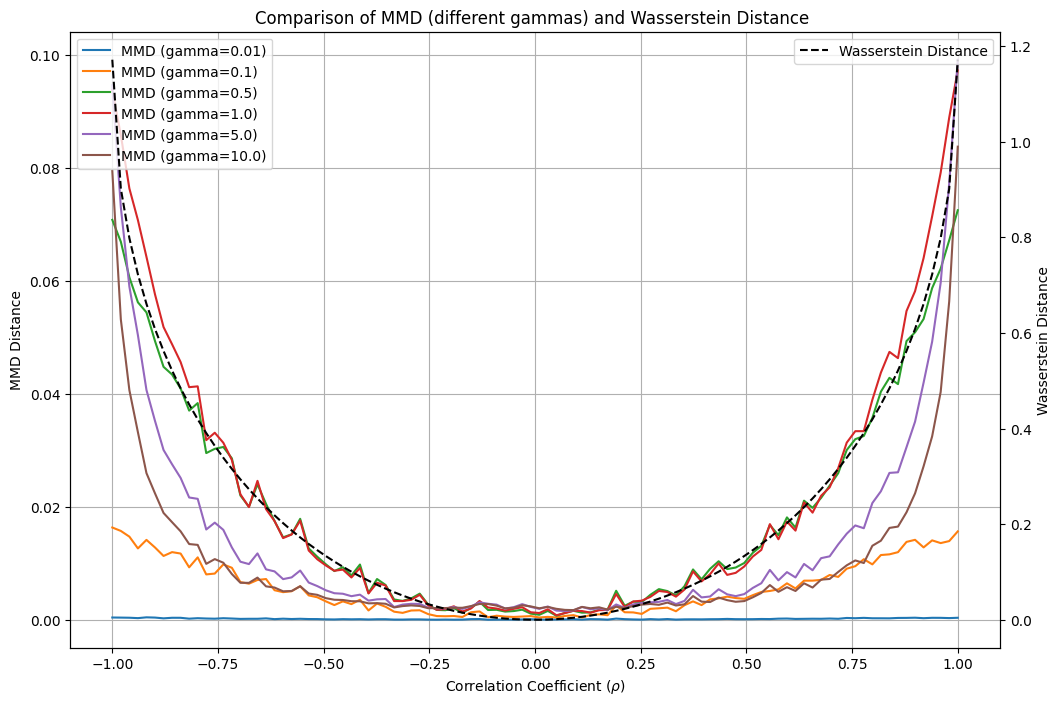

In [16]:
# Plotting with MMD on the left y-axis and Wasserstein on the right y-axis
fig, ax1 = plt.subplots(figsize=(12, 8))

for gamma, mmd_values in mmd_values_dict.items():
    ax1.plot(correlations, mmd_values, label=f'MMD (gamma={gamma})')

ax1.set_xlabel('Correlation Coefficient ($\\rho$)')
ax1.set_ylabel('MMD Distance')
ax1.set_title('Comparison of MMD (different gammas) and Wasserstein Distance ')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for Wasserstein distance
ax2 = ax1.twinx()
ax2.plot(correlations, wasserstein_values, label='Wasserstein Distance', color='black', linestyle='--')
ax2.set_ylabel('Wasserstein Distance')
ax2.legend(loc='upper right')
plt.savefig("MMDvsWasserstein.png")
plt.show()
